In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

data4 = pd.read_excel (r'C:\Users\callu\Dropbox\University\Year 3\Block 2b\Project\17D.xls')

In [14]:
class TES(object):
    '''
    
    Methods:
    self.plotPV() - plots PV graph
    self.plotIV() - plots IV graph
    self.plotPR() - plots PR graph
    self.plotRegions(raw=1) - set raw to false to plot analysed IV regions
    
    #TODO - Store the temperatures in the object
    '''
    
    def __init__(self, rawIV, params = 0, R_stray = 0): 
        ''' Creates a TES object from a pandas dataframe. 
        
        Reads the first two coloums of the dataframe and saves 
        them as attributes. Dataframe can consist of more coloums but they are ignored. 
        Params can be a list or tuple of values in this order [R_fb, M_ratio, R_shunt]
        R_stray can be inlcuded as extra paramter. Doing so will prevent the calc_R_stray method being used to 
        generate a value.
        
        Attriutes after initialisation:
        rawI (np.array[floats]), rawV (np.array[floats])
        raw_grad/raw_2grad (list[floats]) - 1st and 2nd differentials of rawIV
        superconducting (bool) - whether the data shows signs of superconductivity
        y_offset (float) 
        I_TES (list[floats]), V_bias (list[floats]) - Calibrated data
        R_fb, M_ratio, R_shunt (floats)- experimental parameters
        gain (float) - calcuated from M_ratio and R_fb
        R_stray (float) - either input or calculated
        P_TES , R_TES (floats) - Power and Resistance values
        rnn (float) 
        
        ohmic_reg, trans_reg, super_reg (ints) the demarcated regions. 
        If not super conducting ohmic_reg will be the entire data range
        '''
        
        # Drop NaNs in spreadsheet to prevent errors later 
        self.rawI = (rawIV.iloc[:,0].dropna()).values #Store as individual np.arrays for more readable code
        self.rawV = (rawIV.iloc[:,1].dropna()).values
        
        self.raw_grad = np.gradient(self.rawV, self.rawI)#Prevents repeated calls to gradient function later
        self.raw_2grad = np.gradient(self.raw_grad, self.rawI)
        self.superconducting = self.calc_superconducting() # This needs to be done first as other inits depend
        
        #iniditalise these values with the methods
        
        
        # All needed to calculate adjusted I and V etc. If params are included in initialisation, then they are
        # used. Otherwise defualts are used.
        if params:
            try:
                self.R_fb = params[0]
                self.M_ratio = params[1]
                self.R_shunt = params[2]
            except:
                print("Error: Parameters not correct")
                return
        else:
            print("WARNING: Using defualt paramters")
            self.R_fb = 100099.6
            self.M_ratio = 18.9333333333333
            self.R_shunt = 0.00389
        
        self.gain = 1 / (self.R_fb * self.M_ratio)
        
        self.intercect()
        
        # R_stray can be calculated using the class method or manually set
        
        #self.calc_I_TES() #I_TES must first be generated to find R_Stray
        
        if R_stray:
            self.R_stray = R_stray
        else:
            self.calc_R_stray()
            
         # Doesn't plot, just saves self.rnn
        
    ############################calc_methods############################   
    
    def calc_y_offset_ohmic(self):
        '''
        Input: Threshold percentage (int)
        OutPut: D (float)
        '''
        if self.superconducting:
            self.identify_regions()
            C, D , xvals = self.fit_ohmic(self.rawV, self.rawI)
            self.y_offset = D
            
            self.C = C
            self.D = D
            
            #TODO find out why I did this
            self.rawXvals = xvals
        else:
            C, D = curve_fit(self.f, self.rawV, self.rawI)[0]
            self.y_offset = D
            self.ohmic_reg = [(0, len(self.rawI/2)),(len(self.rawI/2)+1, -1)]
            self.transition_reg = False
            self.super_reg = False
    
    def calc_y_offset(self):
        if self.superconducting:
            self.identify_regions()
            E, F , xvals = self.fit_super(self.rawV, self.rawI)
            self.y_offset = F
            
            self.E = E
            self.F = F
        else:
            C, D = curve_fit(self.f, self.rawV, self.rawI)[0]
            self.y_offset = D
            self.ohmic_reg = [(0, len(self.rawI/2)),(len(self.rawI/2)+1, -1)]
            self.transition_reg = False
            self.super_reg = False
        
    def calc_I_TES(self, tweak=1):
        '''
        Generate I_tes (array) data from tweak(float), y_offset (float), gain (float).
        tweaks not yet used
        '''
        
        self.I_TES = [(entry - self.y_offset) * (10**6) * self.gain for entry in self.rawV]
        
    def calc_V_bias(self, tweak=1):
        '''
        Generates V_bias data
        '''
        self.V_bias = [((self.rawI[i]) * self.R_shunt) - (self.I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
        
    def calc_P_TES(self):
        self.P_TES = [self.I_TES[index] * self.V_bias[index] for index in range(len(self.I_TES))]
        
    def calc_R_TES(self):
        self.R_TES = [self.V_bias[i] / self.I_TES[i] for i in range(len(self.V_bias))]
        
    def calc_superconducting(self):
        '''
        Test if the gradient deviates from the average by a significant margin. And save result in attribute.
        Returns the boolean value of self.superconducting
        '''
        grad = self.raw_grad
        grad_av = sum(grad)/len(grad)
        if max(grad) > 3*(grad_av) and abs(min(grad)) > 5*(grad_av):
            self.superconducting = True
        else:
            self.superconducting = False
    
        return self.superconducting
    
    def calc_R_stray(self, start = 0 , end = 0.0008, step = 0.0000001):
        '''
        Go through a range of R_strays and find the one which gives the least error when compared to the yaxis. 
        Then set this as self.rstray
        Inputs:
        start, end and step : (floats)
        used in np.arange function that searches for R_stray. So the precision of R_stray value will depend on these.
        threshold: (float)
        The margin around the axis which you want to consider for catching points. 
        '''
        #Initialise lists for storage of results
        resists = []
        scores = []

        for resist in np.arange(start, end, step):
            V_bias = []
            start , stop = self.super_reg[0]
            
            for index in range(start, stop):
                        V_bias.append((self.newI[index] * self.R_shunt) - (self.I_TES[index]*(self.R_shunt + resist)))
            score = 0
            for entry in V_bias:
                    score += abs(entry)**2

            # Scores are errors, make a list so we can find the resistance that has lowest error
            scores.append(score)
            resists.append(resist)
        plt.show()
        plt.plot(resists, scores)
        plt.show()
        self.R_stray = resists[np.argmin(scores)]
    
    ############################utility methods############################   
    
    def f(self, x, A, B):
        ''' 
        Function of straight line for optimisation function to find
        coefficients for.
        '''
        return A*x + B
        
    def identify_regions(self):
        ''' Identifies the different regions of data (ohmic/transition/superconducting) and saves thier indices
        '''
        
        #Check if the data is superconducting, does not proceed if not.
        if not self.superconducting:
            print("Error: TES is not superconducting")
            return 1
        
        ohmic_reg = []
        trans_reg = []
        super_reg = []
        
        index = 0
        ohmic_grad = sum(self.raw_grad[:20])/20
        
        
        #Identify first ohmic region by when the gradient deviates from average of original 
        while True:
            if self.raw_grad[index] < ohmic_grad * 0.99:
                ohmic_reg.append((0, index - 1))
                break

            index += 1

        start = index
        #When the gradient becomes positive once again this indicates superconductivty 
        while True:
            if self.raw_grad[index] > ohmic_grad * 2:
                trans_reg.append((start, index-1))
                break
            index += 1

        start = index
        #When the gradient becomes negative again, second transition region
        while True:
            if self.raw_2grad[index] < min(self.raw_2grad)/10 and self.raw_grad[index] > 0:
                index+=1
                super_reg.append((start,index))
                break
            index += 1

        start = index + 1 
        # No longer trans when the gradient returns to the ohmic
        while True:
            if self.raw_grad[index] > ohmic_grad * 0.99:
                trans_reg.append((start, index))
                break
            index += 1
        
        # The rest of the indices are assumed to be ohmic again
        ohmic_reg.append((index + 1, len(self.raw_grad) - 1))
        
        # Save the reions as attributes in the object
        self.ohmic_reg = ohmic_reg
        self.trans_reg = trans_reg
        self.super_reg = super_reg
        
    def fit_ohmic(self, inputdataX, inputdataY):
        ''' 
        Accepts two lists for X and Y vals and a tuple of indices. These are then used 
        to fit a straight line to the straight regions.
        Returns C, D, xvals. Which are the gradient, intercept and range of the fitted curve.
        '''
    
        r1start, r1end = (0,7)
        r2start, r2end = (-7,-1)
        
        firstx = min(inputdataX)
        lastx = max(inputdataX)
        xvals = np.linspace(firstx, lastx)

        #Slice the data in the frame and store in an array 
        yvals1 = inputdataY[r1start:r1end]
        yvals2 = inputdataY[r2start:r2end]
        lineDataY = np.append(yvals1, yvals2)
        
        xvals1 = inputdataX[r1start:r1end]
        xvals2 = inputdataX[r2start:r2end]
        lineDataX = np.append(xvals1, xvals2)

        #fit the sliced data to a line
        C, D = curve_fit(self.f, lineDataX, lineDataY)[0]

        return C , D , xvals
    
    def fit_super(self, inputdataX, inputdataY):
        ''' 
        Accepts two lists for X and Y vals. These are then used 
        to fit a straight line to the straight superconducting region.
        Returns C, D, xvals. Which are the gradient, intercept and range of the fitted curve.
        '''
    
        super_start, super_end = self.super_reg[0]
        
        firstx = inputdataX[super_start]
        lastx = inputdataX[super_end]
        xvals = np.linspace(firstx, lastx)

        #Slice the data in the frame and store in an array 
        yvals = inputdataY[super_start:super_end]
        xvals = inputdataX[super_start:super_end]
        
        #fit the sliced data to a line
        C, D = curve_fit(self.f, xvals, yvals)[0]

        return C , D , xvals
    
    def power_readout(self):
        p_grad = np.gradient(self.P_TES, self.V_bias)
        constants = []
        for i in range(len(p_grad)):
            if abs(p_grad[i]) < 0.1:
                constants.append(self.P_TES[i])
        if len(constants):
            ans = sum(constants)/len(constants)
        else:
            ans = 0
        return ans
    
    ###############Plotting Methods###################
    def plotIV(self, plot = True):
        '''
        Plots the calibrated IV curve if plot is set to true in the args. Otherwise just calcs R_nn
        '''
        C, D , Axvals = self.fit_ohmic(self.V_bias, self.I_TES)
        self.rnn = 1/C
        if plot:
            fig, ax = plt.subplots()
            plt.plot(Axvals, self.f(Axvals, C , D), color='r', label='Load Line')
            plt.grid()
            plt.scatter(self.V_bias, self.I_TES, label='TES IV')
            ax.set_xlabel("Voltage (mV)")
            ax.set_ylabel("TES Current (mA)")
            plt.title("Calibrated IV Curve")
            ax.legend()
            
    def plotPR(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.plot(self.R_TES, self.P_TES, label='TES PR')
        plt.title("Power vs Resistance Curve")
        ax.set_xlabel("TES Resistance (ohm)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.calc_superconducting():
            readout = self.power_readout()
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.axvline(self.rnn, color='r',label='Rnn: ' + str(round(self.rnn,5)))
        plt.legend()
    
    def plotPV(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.scatter(self.V_bias, self.P_TES, label='TES PV')
        plt.title("Power Curve")
        ax.set_xlabel("Voltage (mV)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.superconducting:
            readout = self.power_readout()
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.legend()
        
    def plotRegions(self, raw = True):
        '''
        Currently only works for supercondicting
        '''
        fig, ax = plt.subplots()
        if raw:
            ohmic_data = np.append(self.rawI[:(self.ohmic_reg[0][1])], self.rawI[self.ohmic_reg[1][0]:])
            ohmic_V = np.append(self.rawV[:(self.ohmic_reg[0][1])],self.rawV[self.ohmic_reg[1][0]:])

            trans_data = np.append(self.rawI[self.trans_reg[0][0]: self.trans_reg[0][1]], self.rawI[self.trans_reg[1][0]:self.trans_reg[1][1]])
            trans_V = np.append(self.rawV[self.trans_reg[0][0]: self.trans_reg[0][1]], self.rawV[self.trans_reg[1][0]:self.trans_reg[1][1]])

            super_data = self.rawI[self.super_reg[0][0]:self.super_reg[0][1]]
            super_V = self.rawV[self.super_reg[0][0]:self.super_reg[0][1]]
            
            plt.scatter(ohmic_data, ohmic_V, label='Ohmic')
            plt.scatter(trans_data, trans_V, label='Transition')
            plt.scatter(super_data, super_V, label='Superconducting')
            ax.set_xlabel("I Bias (mA)")
            ax.set_ylabel("V Feedback (V)")
            plt.title("Raw IV Curve")
            plt.grid()
            plt.legend()
            plt.show()
        else:
            ohmic_data = np.append(self.I_TES[:(self.ohmic_reg[0][1])], self.I_TES[self.ohmic_reg[1][0]:])
            ohmic_V = np.append(self.V_bias[:(self.ohmic_reg[0][1])],self.V_bias[self.ohmic_reg[1][0]:])

            trans_data = np.append(self.I_TES[self.trans_reg[0][0]: self.trans_reg[0][1]], self.I_TES[self.trans_reg[1][0]:self.trans_reg[1][1]])
            trans_V = np.append(self.V_bias[self.trans_reg[0][0]: self.trans_reg[0][1]], self.V_bias[self.trans_reg[1][0]:self.trans_reg[1][1]])

            super_data = self.I_TES[self.super_reg[0][0]:self.super_reg[0][1]]
            super_V = self.V_bias[self.super_reg[0][0]:self.super_reg[0][1]]
            
            plt.scatter(ohmic_V, ohmic_data, label='Ohmic')
            plt.scatter(trans_V, trans_data, label='Transition')
            plt.scatter(super_V, super_data, label='Superconducting')
            
            ax.set_xlabel("Voltage (mV)")
            ax.set_ylabel("TES Current (mA)")
            plt.title("Calibrated IV Curve")
            plt.grid()
            plt.legend()
            plt.show()
        
        
        
    ###############Methods TODO###################
    def smooth_IV(): #Remove qunatum jumps?
        #TODO
        ''' Maybe a function to smooth noisy data before we find the 
        y offset. 
        Inputs: rawIV (or just use self?)
        Outputs: stores smoothRawIV in self
        '''
        pass
    
    def reject_outliers(self, data, m = 2.):
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    
    def intercect(self):
        self.calc_y_offset()
        self.calc_y_offset_ohmic()
        
        x = (self.D - self.F)/(self.E - self.C)
        y = self.C * (x) + self.D
        
        self.intercept = (x,y)
        self.x_offset = y
        self.y_offset = x
        
        C, D , Axvals1 = self.fit_ohmic(self.rawI, self.rawV)
        E, F , Axvals2 = self.fit_super(self.rawI, self.rawV)
        
        plt.scatter(self.rawI, self.rawV)
        plt.plot(Axvals1, self.f(Axvals1, C , D), color='r', label='Ohmic Line')
        plt.plot(Axvals2, self.f(Axvals2, E , F), color='g', label='Super Line')
        
        self.newI = [entry - y for entry in self.rawI]
        self.newV = [entry - x for entry in self.rawV]
        self.calc_I_TES()
        self.calc_R_stray()
        devs = []
        ys = []
        counts = []
        i = 0
        for y_off in np.arange(-1,1,0.001):
            I_TES = [(entry - y_off) * (10**6) * self.gain for entry in self.rawV]
            V_bias = [((self.rawI[i]) * self.R_shunt) - (I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
            P_TES = [I_TES[index] * V_bias[index] for index in range(len(self.I_TES))]
            P_grad = np.gradient(P_TES)
            P_grad_smooth = self.reject_outliers(P_grad)
            R_TES = [V_bias[i] / I_TES[i] for i in range(len(V_bias))]
            count =0
            for entry in P_grad_smooth:
                count += abs(entry)**2
            for i in range(self.ohmic_reg[0][1]):
                count += (R_TES[-i] - R_TES[i])**2
                    
            
            #devs.append(np.average(abs(P_grad)))
            ys.append(y_off)
            counts.append(count)
            #if False:#i % 1000 == 0:
                #plt.show()
                #plt.plot(V_bias,P_grad)
                #plt.savefig(str(y_off)+'.png')
            #i += 1
        #print(min(devs))
        
        self.y_offset = ys[np.argmin(counts)]
        #print(max(devs))
        #self.R_TES = [self.V_bias[i] / self.I_TES[i] for i in range(len(self.V_bias))]
        plt.show()
        plt.plot(self.newI,self.newV)
        print(x,y)
        
    def y_search(self, step, pivot, precision):
        if step <= precision:
            self.y_offset = pivot
            return pivot
        
        ys = []
        counts = []
        
        for y_off in np.arange(pivot-(10*step),pivot+(step*10),step/10):
            I_TES = [(entry - y_off) * (10**6) * self.gain for entry in self.rawV]
            V_bias = [((self.rawI[i]) * self.R_shunt) - (I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
            P_TES = [I_TES[index] * V_bias[index] for index in range(len(self.I_TES))]
            P_grad = np.gradient(P_TES)
            P_grad_smooth = self.reject_outliers(P_grad)
            R_TES = [V_bias[i] / I_TES[i] for i in range(len(V_bias))]
            count =0
            for entry in P_grad_smooth:
                count += abs(entry)**2
            for i in range(self.ohmic_reg[0][1]):
                count += (R_TES[-i] - R_TES[i])**2
            counts.append(count)
            ys.append(y_off)
        
        y_offset = ys[np.argmin(counts)]
        self.y_search(step/10, y_offset, precision)

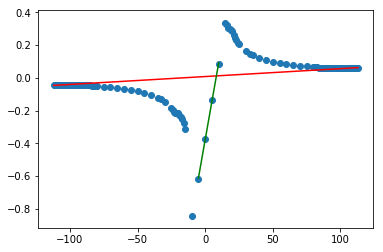

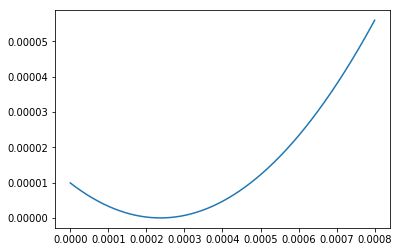

0.011727636615479393 8.300530842442857


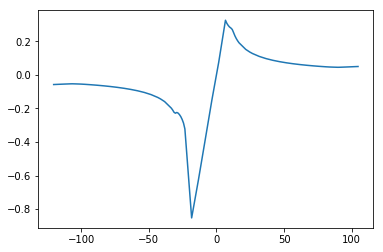

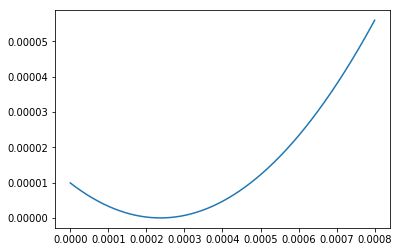

In [15]:
params = [3002.9, 18.93333, 0.001115]
RT = TES(data4, params)

In [13]:
print(RT.y_offset)
RT.y_search(0.1, 0, 0.0000000001)
print(RT.y_offset)

0.008000000000000895
0.007661218350000967


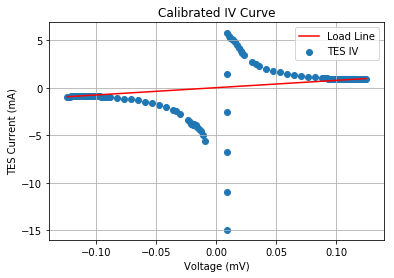

In [5]:
RT.calc_I_TES()
RT.calc_V_bias()
RT.plotIV()

In [6]:
RT.R_stray

0.00023679999999999998

In [366]:
RT.calc_P_TES()
RT.calc_R_TES()

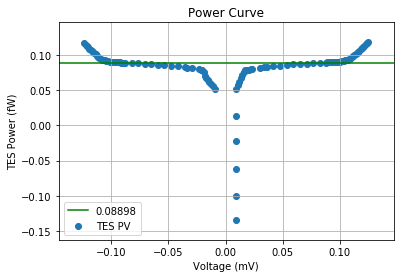

In [367]:
RT.plotPV()

0.007661218350000967


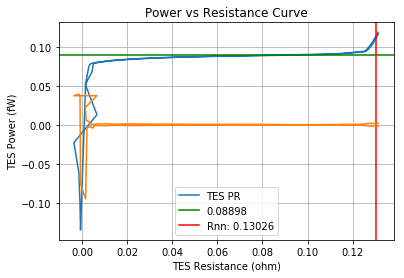

In [372]:
RT.plotPR()
grad1 = np.gradient(RT.P_TES)#,RT.R_TES)
plt.plot(RT.R_TES, grad1)
print(RT.y_offset)

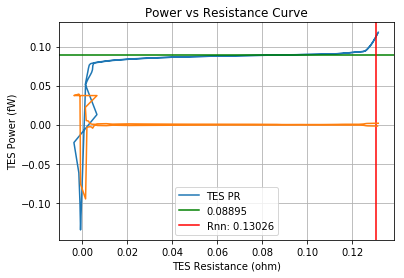

In [316]:
RT.y_offset = 0.007753
RT.calc_I_TES()
RT.calc_V_bias()
RT.calc_P_TES()
RT.calc_R_TES()
RT.plotPR()
grad1 = np.gradient(RT.P_TES)
plt.plot(RT.R_TES, grad1)

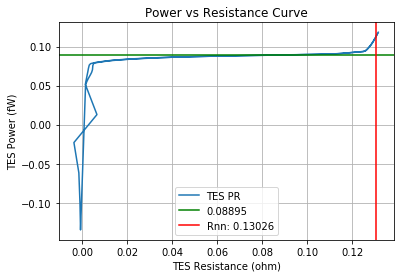

In [289]:
RT.plotPR()